<p  style="text-align: center;"><font size="10"><b>PREDICTING BREAST CANCER IN WISCONSIN</b></font></p>


Using data from a digitized images of a brest mass in the state of Wisconsin, this notebook will use feature selection and model building using several different algorithms to attempt to predict whether a breast mass is benign or malignant. 

<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of Contents</h3>

* <a href='#1'>I. LOAD LIBRARIES & PACKAGES</a>
* <a href='#2'>II. LOAD LIBRARIES & PACKAGES</a>
* <a href='#3'>III. LOAD LIBRARIES & PACKAGES</a>
* <a href='#4'>IV. LOAD LIBRARIES & PACKAGES</a>
* <a href='#5'>V. LOAD LIBRARIES & PACKAGES</a>
* <a href='#6'>VI. LOAD LIBRARIES & PACKAGES</a>

2. [Initial Insights](#insights)
3. [Data Preprocessing & Feature Engineering](#preprocessing)
4. [Data Exploration & Visualization](#exploration)
5. [Feature Selection](#features)  
6. [Model Building](#models)  
    A. [Random Forest](#rf)  
    B. [Random Forest w Select K Best](#rfkbest)  
    C. [Support Vector Machine](#svm)  
    D. [Logistic Regression](#lr)  
    E. [Decision Tree](#dt)  
    F. [K Nearest Neighbors](#knn) 
7. [Algorithm Comparison](#comparison)
8. [Conclusion](#conclusion) 

# <a id='1'>I. LOAD LIBRARIES & PACKAGES</a>

In [1]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       ha878542_0         137 KB  conda-forge
    certifi-2020.12.5          |   py37h89c1867_1         143 KB  conda-forge
    conda-4.9.2                |   py37h89c1867_0         3.0 MB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-pyhd1c1de3_3

The following packages will be UPDATED:

  ca-certificates                      2020.6.20-hecda079_0 --> 2020.12.5-ha878542_0
  certifi                          2020.6.2

In [2]:
!pip install --upgrade scikit-learn==0.20.3

     |████████████████████████████████| 5.4 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tpot 0.11.5 requires scikit-learn>=0.22.0, but you'll have scikit-learn 0.20.3 which is incompatible.
sklearn-pandas 2.0.0 requires scikit-learn>=0.23.0, but you'll have scikit-learn 0.20.3 which is incompatible.
kmeans-smote 0.1.2 requires imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.7.0 which is incompatible.
kmeans-smote 0.1.2 requires numpy<1.16,>=1.13, but you'll have numpy 1.18.5 which is incompatible.
imbalanced-learn 0.7.0 req

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
%matplotlib inline 

import itertools


#EVALUATION ALGORITHMS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn import metrics
# from sklearn.metrics import jaccard_score
from sklearn.externals.six import StringIO
from sklearn import tree

import pydotplus

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-wisconsin-data/data.csv


# <a id='2'>II. DATA OVERVIEW AND INSIGHTS</a>

In [4]:
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')

In [5]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
df.shape

(569, 33)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [8]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


# <a id='3'>III. DATA WRANGLING</a>

In [9]:
# SHAPE OF FEATURE DATASET

df.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
Y = df.diagnosis
X = df.drop('diagnosis', axis=1)
X.shape

(569, 30)

In [10]:
#DATA STANDARDIZATION
X_std = (X - X.mean()) / (X.std())

# <a id='4'>IV. EXPLORATORY DATA ANALYSIS</a>

This section will use visualization techniques to get an overview of the data and the correlation between each feature and the target variable. 

Using violin and swarm plots we'll be able to see what kind of distinctions there are between benign and malignant cases and their respective feature variables. 

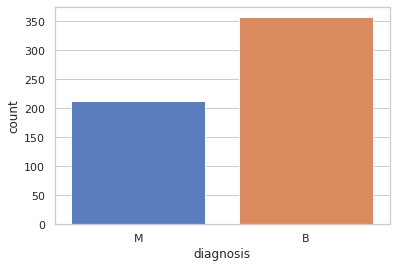

Benign:  357
Malignant :  212


In [59]:
#VISUALIZE NUMBER OF BENIGN AND MALIGNANT CASES

sns.countplot(df['diagnosis'], label='Count')
plt.show()

B, M = df['diagnosis'].value_counts()
print('Benign: ',B)
print('Malignant : ',M)

In [12]:
# SPLIT DATASET INTO TWO SETS OF 15 FEATURES EACH

df_set1 = pd.concat([Y, X_std.iloc[:, 0:15]], axis=1)
df_set2 = pd.concat([Y, X_std.iloc[:, 15:30]], axis=1)


# TRANSFORM DATA INTO 3 COLUMN DATA FRAME W/ ALL FEATURES IN ONE COLUMN

df_melt1 = pd.melt(df_set1, id_vars="diagnosis", var_name="features", value_name='value')
df_melt2 = pd.melt(df_set2, id_vars="diagnosis", var_name="features", value_name='value')
df_melt1.head()

,diagnosis,features,value
0,M,radius_mean,1.096100
1,M,radius_mean,1.828212
2,M,radius_mean,1.578499
3,M,radius_mean,-0.768233
4,M,radius_mean,1.748758


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

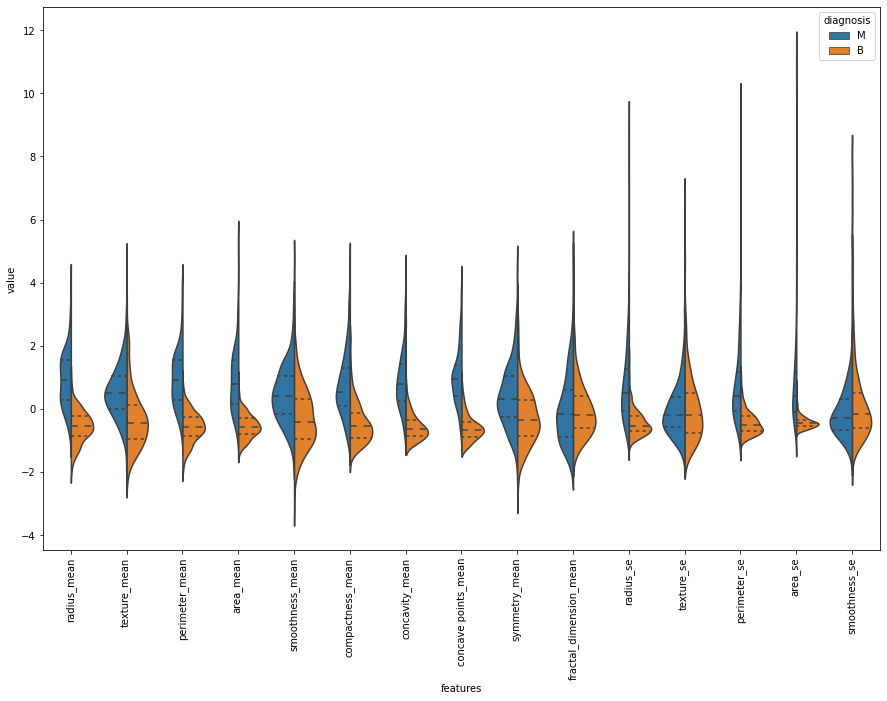

In [13]:
# VIOLIN PLOT TO VISUALIZE BENIGN AND MALIGNANT FEATURE CORRELATIONS

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=df_melt1, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

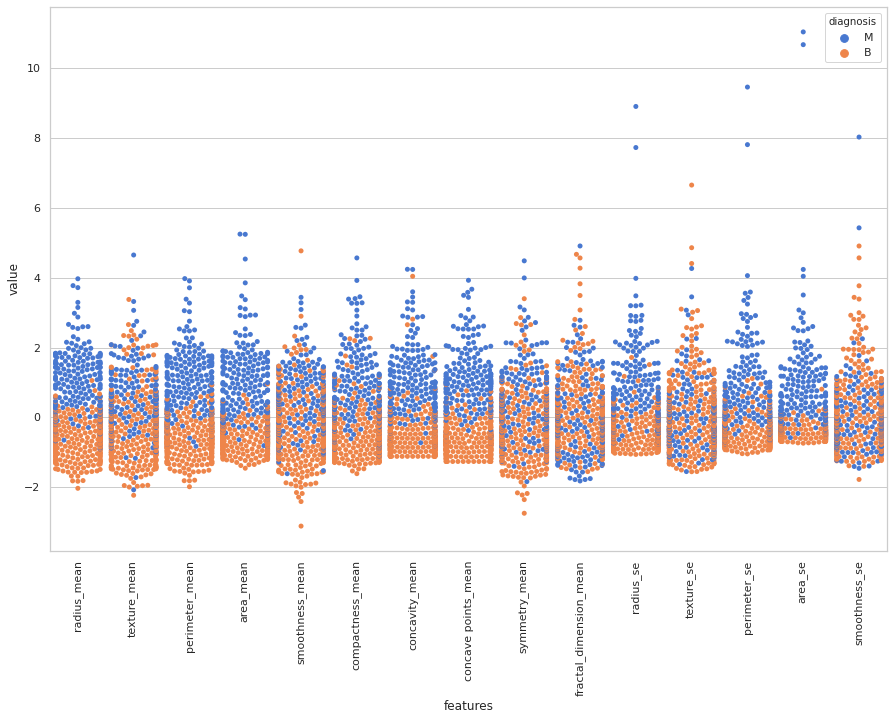

In [14]:
# SWARM PLOT TO VISUALIZE BENIGN AND MALIGNANT FEATURE CORRELATIONS

sns.set(style='whitegrid', palette='muted')

plt.figure(figsize=(15,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=df_melt1)
plt.xticks(rotation=90)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

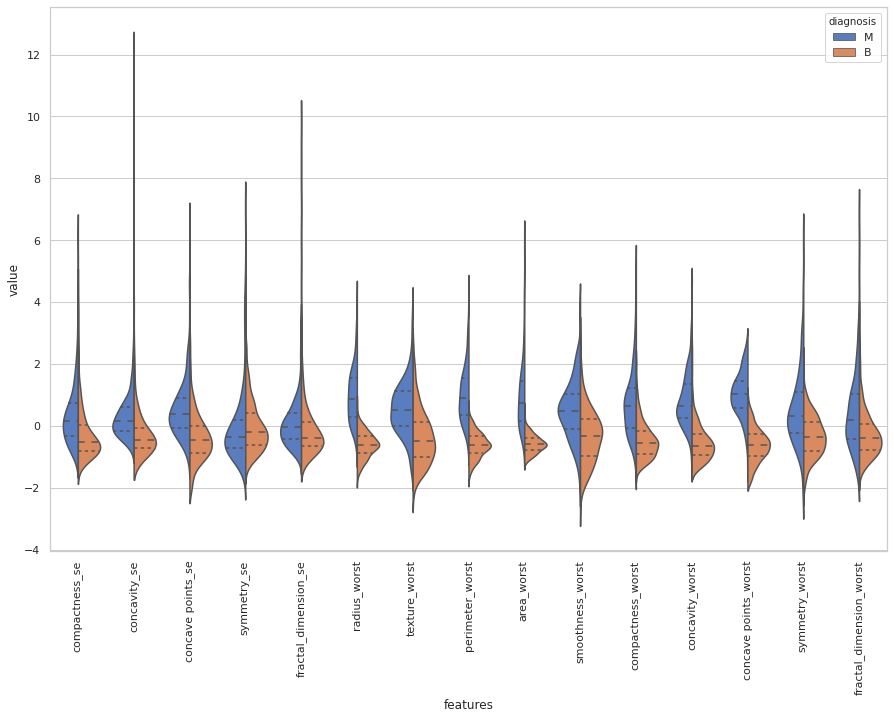

In [15]:
# VIOLIN PLOT TO VISUALIZE BENIGN AND MALIGNANT FEATURE CORRELATIONS

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=df_melt2, split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

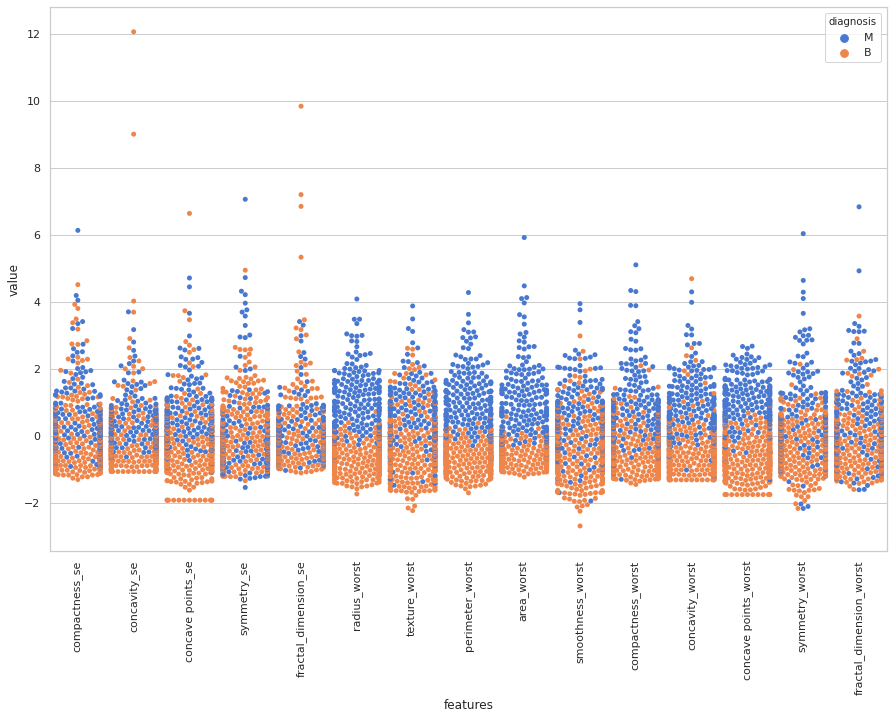

In [16]:
# SWARM PLOT TO VISUALIZE BENIGN AND MALIGNANT FEATURE CORRELATIONS

sns.set(style='whitegrid', palette='muted')

plt.figure(figsize=(15,10))
sns.swarmplot(x="features", y="value", hue="diagnosis", data=df_melt2)
plt.xticks(rotation=90)
plt.show()

# <a id='5'>FEATURE SELECTION</a>

We will narrow down our features by using a heatmap to visualize the correlation between variables and eliminating those features that are fully correlated. 

Text(0.5, 1.0, 'FEATURE VARIABLE CORRELATIONS')

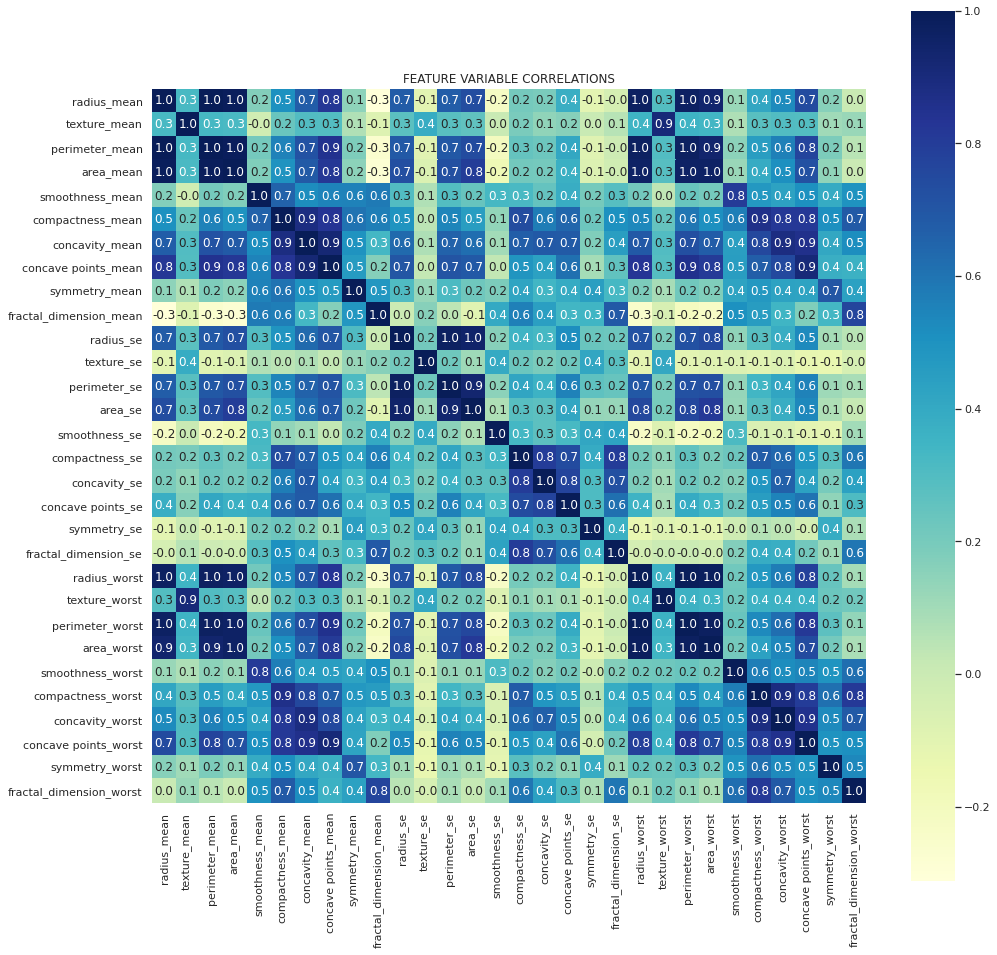

In [17]:
# CREATE HEATMAP TO VISUALIZE DATA CORRELATIONS

plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), cbar = True,  square = True, annot=True, fmt= '.1f', annot_kws={'size': 12},
           xticklabels=X.columns, yticklabels=X.columns,
           cmap= 'YlGnBu')
plt.title('FEATURE VARIABLE CORRELATIONS')
plt.show()

Several features have a 100% correlation. For instance, **radius_mean**, **perimeter_mean**, and **area_mean** are all 100% correlated so we can keep one and eliminate the rest. We'll keep **area_mean**. 

This step will be repeated for the other features until we have a feature set that is narrowed down to the most essential features. 

In [18]:
# CREATE NEW FEATURE SET 

features = ['area_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
        'area_se', 'texture_se', 'smoothness_se', 'compactness_se', 'symmetry_se', 'fractal_dimension_se',
        'area_worst', 'texture_worst', 'smoothness_worst', 'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst']
X_1 = X[features]


# <a id='VI'>VI. MODEL BUILDING</a>

Using our new feature set we will build several models to determine which method is best for predicting the outcome of our target variable, diagnosis. 

We will then evaluate the accuracy of each model using **accuracy_score**, **F1_Score**, **Confusion Matrix**, and **Log Loss**

### MODELS USED:
1. RANDOM FOREST
2. RANDOM FOREST USING SELECT K BEST FEATURES
3. SUPPORT VECTOR MACHINE
4. LOGISTIC REGRESSION
5. DECISION TREE
6. K NEAREST NEIGHBOR

In [19]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
import itertools

<a id="rf"></a>
### RANDOM FOREST CLASSIFICATION

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Accuracy Score:  0.9181286549707602


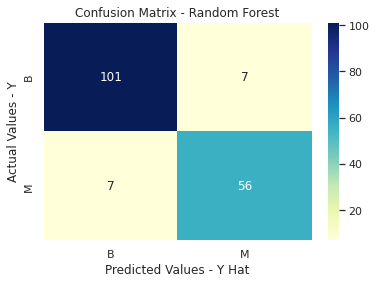

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_1, Y, test_size=0.3, random_state=1)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
yhat_rf = clf_rf.predict(X_test)
yhat_proba_rf = clf_rf.predict_proba(X_test)

ac_rf = accuracy_score(y_test, yhat_rf)
print('Accuracy Score: ', ac_rf)

cm_rf = confusion_matrix(y_test, yhat_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
plt.xlabel('Predicted Values - Y Hat')
plt.ylabel('Actual Values - Y')
plt.title('Confusion Matrix - Random Forest')

plt.show()

#### F1 SCORE

In [21]:
f1_rf = f1_score(y_test, yhat_rf, average='weighted') 
print('F1 Score: ', f1_rf)

F1 Score:  0.9470870627956459


In [22]:
log_loss_rf = log_loss(y_test, yhat_proba_rf)
log_loss_rf

0.16045259944725188

<hr>

<a id="rfkbest"></a>
### SELECT K BEST AND RANDOM FOREST

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [24]:
y_train

249    B
58     B
476    B
529    B
422    B
      ..
129    M
144    B
72     M
235    B
37     B
Name: diagnosis, Length: 398, dtype: object

In [25]:
select_features = SelectKBest(chi2, k=9).fit(X_train, y_train)
X_train.columns[select_features.get_support()]

Index(['area_mean', 'texture_mean', 'compactness_mean', 'area_se',
       'compactness_se', 'area_worst', 'texture_worst', 'compactness_worst',
       'symmetry_worst'],
      dtype='object')

In [26]:
feature_scores = pd.DataFrame(X_train.columns, columns=['Features'])
feature_scores['scores'] = select_features.scores_
feature_scores = feature_scores.sort_values(by='scores', ascending=False)

Accuracy Score:  0.935672514619883


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



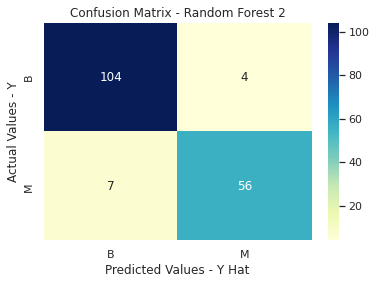

In [60]:
X_train_2 = select_features.transform(X_train)
X_test_2 = select_features.transform(X_test)

clf_rf2 = RandomForestClassifier()
clf_rf2.fit(X_train_2, y_train)
yhat_rf2 = clf_rf2.predict(X_test_2)
yhat_proba_rf2 = clf_rf2.predict_proba(X_test_2)

ac_rf2 = accuracy_score(y_test, yhat_rf2)
print('Accuracy Score: ', ac_rf2)

cm_rf_kbest = confusion_matrix(y_test, yhat_rf2)
sns.heatmap(cm_rf_kbest, annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
plt.xlabel('Predicted Values - Y Hat')
plt.ylabel('Actual Values - Y')
plt.title('Confusion Matrix - Random Forest 2')
plt.show()

#### F1_SCORE

In [28]:
f1_rf2 = f1_score(y_test, yhat_rf2, average='weighted')
print('F1 Score: ', f1_rf2)

F1 Score:  0.9240991142936998


#### LOG LOSS

In [29]:
log_loss_rf2 = log_loss(y_test, yhat_proba_rf2)
log_loss_rf2

0.36046331575593193

<a id="svm"></a>
### SUPPORT VECTOR MACHINE

In [30]:
clf_svm = svm.SVC(kernel='rbf', probability=True)
clf_svm.fit(X_train, y_train)
yhat_svm = clf_svm.predict(X_test)
yhat_proba_svm = clf_svm.predict_proba(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score:  0.631578947368421


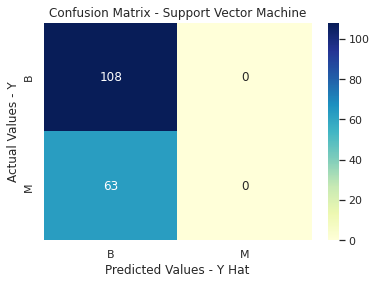

In [62]:
ac_svm = accuracy_score(y_test, yhat_svm)
print('Accuracy Score: ', ac_svm)

cm_svm = confusion_matrix(y_test, yhat_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
plt.xlabel('Predicted Values - Y Hat')
plt.ylabel('Actual Values - Y')
plt.title('Confusion Matrix - Support Vector Machine')
plt.show()

#### F1_SCORE

In [32]:
f1_svm = f1_score(y_test, yhat_svm, average='weighted')
print('F1 Score: ', f1_svm)

F1 Score:  0.48896434634974534


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### LOG LOSS

In [33]:
log_loss_svm = log_loss(y_test, yhat_proba_svm)
log_loss_svm

0.6656208654949265

<a id="lr"></a>
### LOGISTIC REGRESSION

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
clf_lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
clf_lr

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
clf_lr.fit(X_train, y_train)
yhat_lr = clf_lr.predict(X_test)
yhat_proba_lr = clf_lr.predict_proba(X_test)

Accuracy Score:  0.8830409356725146


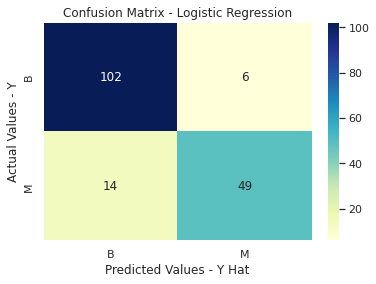

In [63]:
ac_lr = accuracy_score(y_test, yhat_lr)
print('Accuracy Score: ', ac_lr)

cm_lr = confusion_matrix(y_test, yhat_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
plt.xlabel('Predicted Values - Y Hat')
plt.ylabel('Actual Values - Y')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

#### F1 SCORE

In [38]:
f1_lr = f1_score(y_test, yhat_lr, average='weighted') 
print('F1 Score: ', f1_lr)

F1 Score:  0.8811647763476488


In [39]:
print (classification_report(y_test, yhat_lr))

              precision    recall  f1-score   support

           B       0.88      0.94      0.91       108
           M       0.89      0.78      0.83        63

   micro avg       0.88      0.88      0.88       171
   macro avg       0.89      0.86      0.87       171
weighted avg       0.88      0.88      0.88       171



#### LOG LOSS

In [40]:
log_loss_lr = log_loss(y_test, yhat_proba_lr)
log_loss_lr

0.3187839050792349

<a id="dt"></a>
### DECISION TREE

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
clf_dt = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
clf_dt.fit(X_train, y_train)
yhat_dt = clf_dt.predict(X_test)
yhat_proba_dt = clf_dt.predict_proba(X_test)

In [43]:
metrics.accuracy_score(yhat_dt, y_test)
ac_dt = metrics.accuracy_score(yhat_dt, y_test)
print("DecisionTrees's Accuracy: ", ac_dt)

DecisionTrees's Accuracy:  0.935672514619883


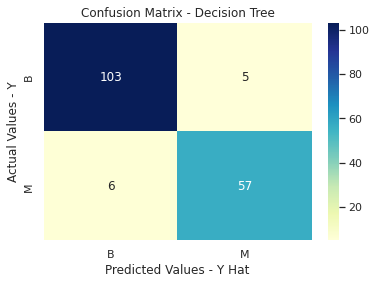

In [64]:
cm_dt = confusion_matrix(y_test, yhat_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
plt.xlabel('Predicted Values - Y Hat')
plt.ylabel('Actual Values - Y')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

#### F1 SCORE

In [45]:
f1_dt = f1_score(y_test, yhat_dt, average='weighted') 
print('F1 Score: ', f1_dt)

F1 Score:  0.9355634246907591


#### LOG LOSS

In [46]:
log_loss_dt = log_loss(y_test, yhat_proba_dt)
log_loss_dt

1.8613772619845528

#### VISUALIZE DECISION TREE

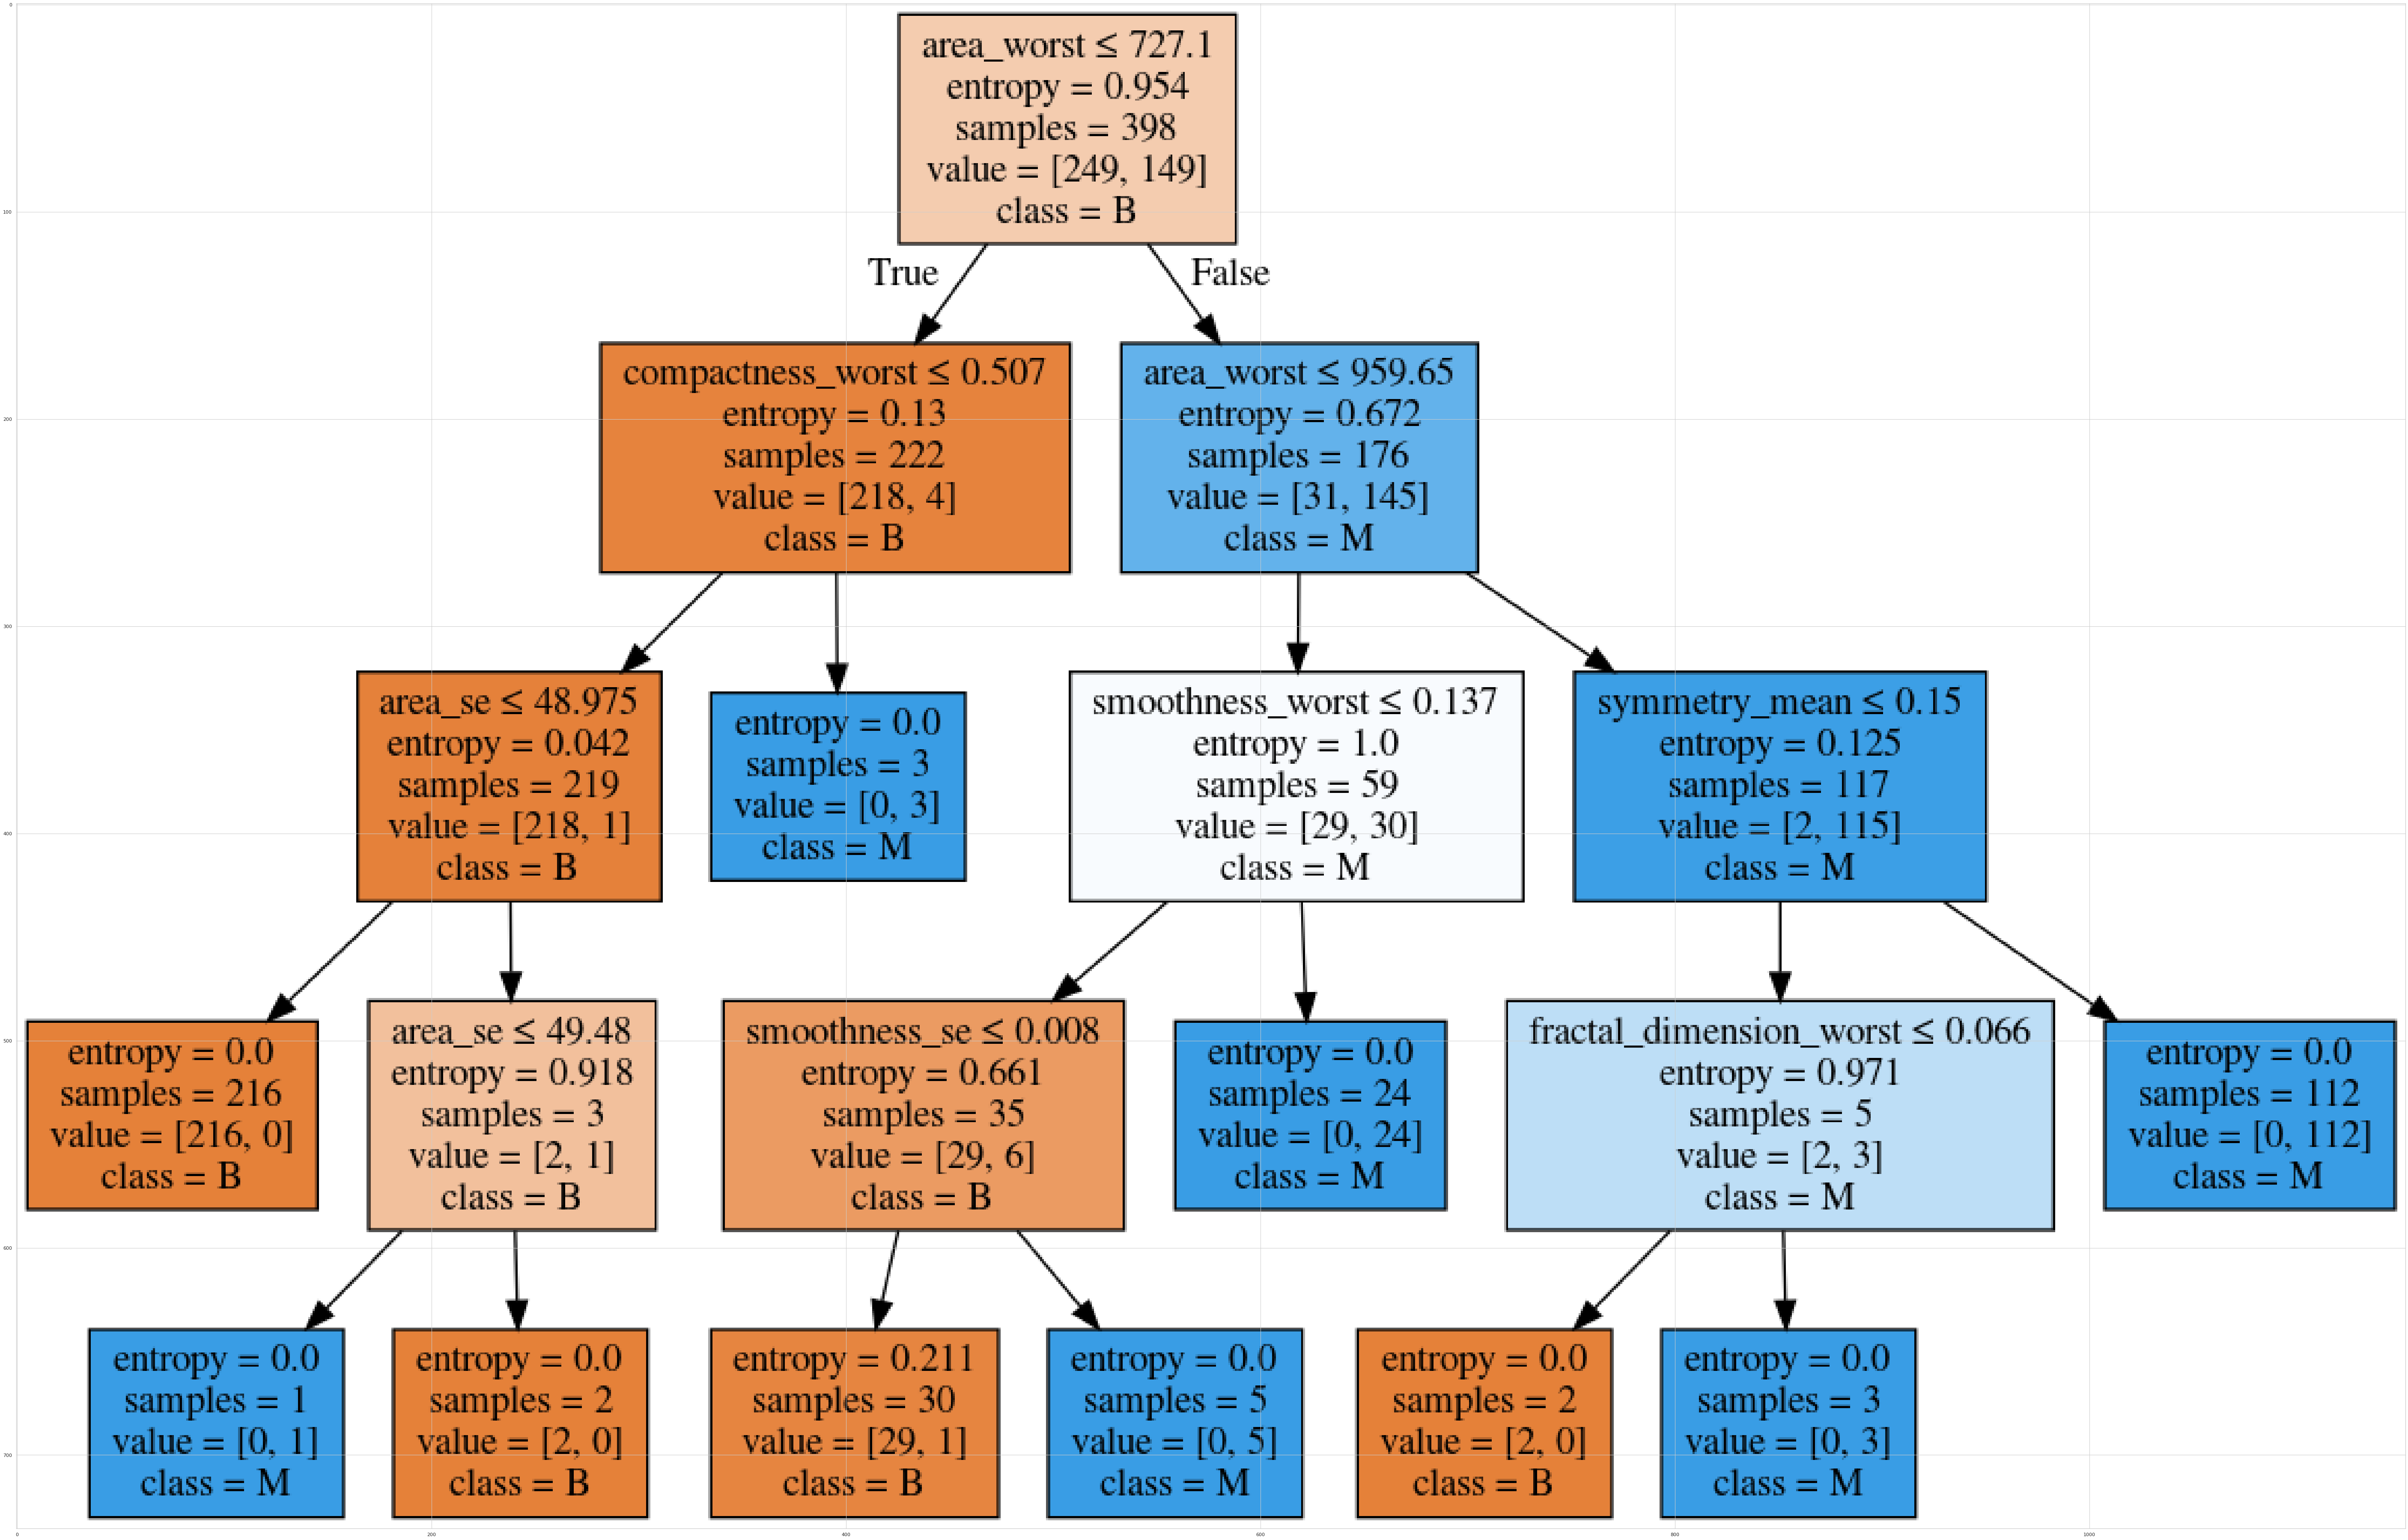

In [65]:
dot_data = StringIO()
filename = "clf_dt.png"
featureNames = X_train.columns[0:18]
targetNames = Y.unique().tolist()
out=tree.export_graphviz(clf_dt,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')
plt.show()

<a id="knn"></a>
### K NEAREST NEIGHBORS

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
k = 7
clf_knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_knn = clf_knn.predict(X_test)
yhat_proba_knn = clf_knn.predict_proba(X_test)

In [50]:
ac_knn = metrics.accuracy_score(y_test, yhat_knn)

print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf_knn.predict(X_train)))
print("Test set Accuracy: ", ac_knn)

Train set Accuracy:  0.9346733668341709
Test set Accuracy:  0.9415204678362573


In [51]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
# ConfusionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    clf_knn = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat_knn=clf_knn.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_knn)

    
    std_acc[n-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])

mean_acc

array([0.90643275, 0.89473684, 0.9122807 , 0.92982456, 0.92397661,
       0.92397661, 0.94152047, 0.92982456, 0.92982456])

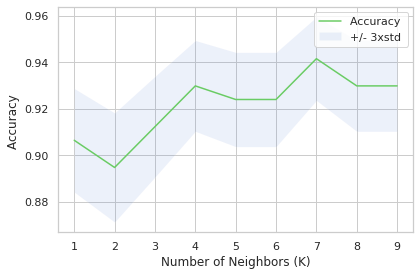

In [52]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

The best accuracy was with 0.9415204678362573 with k = 7


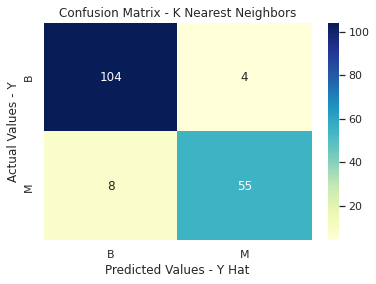

In [66]:
print( "The best accuracy was with", mean_acc.max(), "with k =", mean_acc.argmax()+1) 

cm_knn = confusion_matrix(y_test, yhat_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
plt.xlabel('Predicted Values - Y Hat')
plt.ylabel('Actual Values - Y')
plt.title('Confusion Matrix - K Nearest Neighbors')
plt.show()

#### F1 SCORE

In [54]:
f1_knn = f1_score(y_test, yhat_knn, average='weighted') 
print('F1 Score: ', f1_knn)

F1 Score:  0.9293121029100322


#### LOG LOSS

In [55]:
log_loss_knn = log_loss(y_test, yhat_proba_knn)
log_loss_knn

0.7522875289650608

<a id="comparison"></a>
## CLASSIFICATION ACCURACY COMPARISON

We will do a side by side comparison and a visualization of each algorithm's **accuracy_score**, **f1_score**, and **log loss** to determine which model yielded the best results. 

In [56]:
# CREATE NEW DATAFRAME WITH THE ALGORITHM AND EACH ACCURACY MEASUREMENT. 

d = {'Algorithm' : ['Random Forest', 'Random Forest w/ KBest', 'Support Vector Machine', 'Logistic Regression', 'Decision Tree', 'K Nearest Neighbor'],
     'Accuracy_Score' : [ac_rf, ac_rf2, ac_svm, ac_lr, ac_dt, ac_knn],
    'F1_Score' : [f1_rf, f1_rf2, f1_svm, f1_lr, f1_dt, f1_knn],
    'Log_Loss' : [log_loss_rf, log_loss_rf2, log_loss_svm, log_loss_lr, log_loss_dt, log_loss_knn]}
df_accuracy = pd.DataFrame(data=d)
df_accuracy


,Algorithm,Accuracy_Score,F1_Score,Log_Loss
0,Random Forest,0.947368,0.947087,0.160453
1,Random Forest w/ KBest,0.923977,0.924099,0.360463
2,Support Vector Machine,0.631579,0.488964,0.665621
3,Logistic Regression,0.883041,0.881165,0.318784
4,Decision Tree,0.935673,0.935563,1.861377
5,K Nearest Neighbor,0.941520,0.929312,0.752288


In [57]:
# CREATE BAR CHART TO VISUALIZE EACH ALGORITHM'S ACCURACY MEASUREMENT. 

fig = go.Figure(data=[go.Bar(name='Accuracy_Score', x=df_accuracy['Algorithm'], y=df_accuracy['Accuracy_Score']),
                      go.Bar(name='F1_Score', x=df_accuracy['Algorithm'], y=df_accuracy['F1_Score']),
                      go.Bar(name='Log_Loss', x=df_accuracy['Algorithm'], y=df_accuracy['Log_Loss']),
                     ])

# Change the bar mode
fig.update_layout(barmode='group', title_text='Classification Scores')
fig.show()

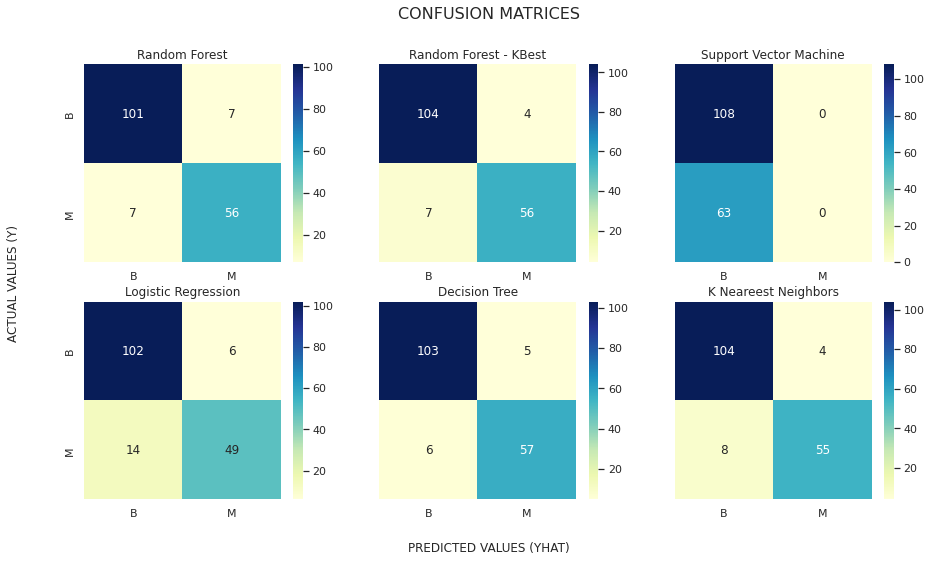

In [67]:
# CREATE SUBPLOTS WITH ALL CONFUSIION MATRICES

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
fig.suptitle("CONFUSION MATRICES", fontsize=16)
fig.text(0.5, 0.04, 'PREDICTED VALUES (YHAT)', ha='center', va='center')
fig.text(0.06, 0.5, 'ACTUAL VALUES (Y)', ha='center', va='center', rotation='vertical')

ax1 = sns.heatmap(cm_rf, ax=axes[0, 0], annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
ax2 = sns.heatmap(cm_rf_kbest,ax=axes[0, 1], annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
ax3 = sns.heatmap(cm_svm, ax=axes[0, 2], annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
ax4 = sns.heatmap(cm_lr, ax=axes[1, 0], annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
ax5 = sns.heatmap(cm_dt, ax=axes[1, 1], annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')
ax6 = sns.heatmap(cm_knn, ax=axes[1, 2], annot=True, fmt='d', cmap='YlGnBu', xticklabels='BM', yticklabels='BM')

ax1.set_title('Random Forest')
ax2.set_title('Random Forest - KBest')
ax3.set_title('Support Vector Machine')
ax4.set_title('Logistic Regression')
ax5.set_title('Decision Tree')
ax6.set_title('K Neareest Neighbors')


plt.show()

<a id="conclusion"></a>
## CONCLUSION

It appears that the Random Forest algorithm gives us the best chance at accuracy within our dataset with an accuracy score of 93% and Log Loss of 16%. 

Thank you for stopping by! I'd love to recieve some feedback or suggestions on what I could do to improve this kernel. Please leave a comment below. 

-Milton